# Part 3 - Model Selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
path = r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities"
sys.path.append(path)
import plot_settings

In [2]:
data = np.genfromtxt(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\Data\mu_z.txt', delimiter=' ')

In [3]:
z_sample  = data[:, 0]
mu_sample = data[:, 1]
dmu       = data[:, 2]

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ricca\AppData\Local\Temp\ipykernel_6212\2962798895.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


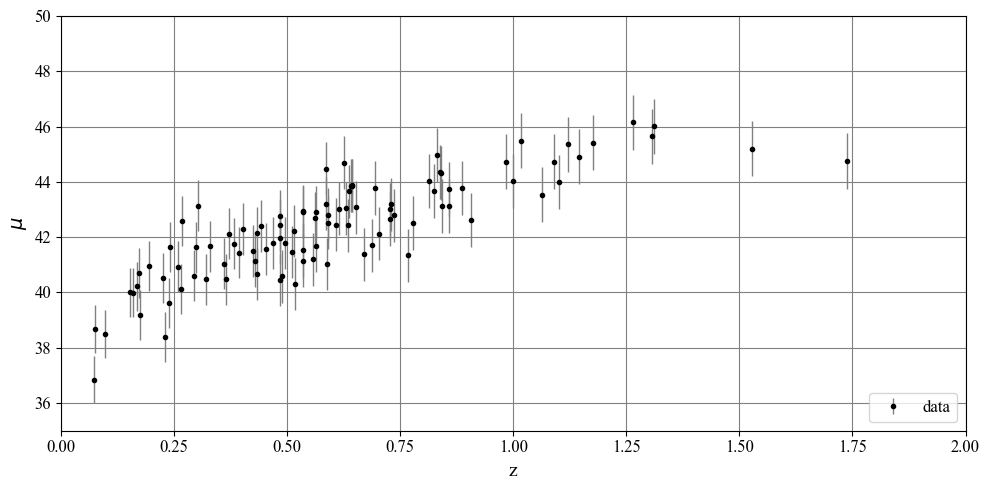

In [4]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

# Nested Sampling

In [5]:
import dynesty

In [25]:
from scipy.integrate import quad

c = 299792.458  # velocità della luce in km/s

def integrand(zp, omega_m):
    return 1.0 / np.sqrt(omega_m * zp**3 + 1)

def mu_theoretical(z, H0, omega_m):
    mu = []
    for zi in z:
        integral, _ = quad(integrand, 0, zi, args=(omega_m,))
        dL = (c / H0) * (1 + zi) * integral  # luminosity distance in Mpc
        mu_i = 5 * np.log10(dL * 1e6 / 10)   # convert Mpc to pc and apply modulus formula
        mu.append(mu_i)
    return np.array(mu)

def mu_theoretical2(z, H0):
    mu = []
    omega_m = 1
    for zi in z:
        integral, _ = quad(integrand, 0, zi, args=(omega_m,))
        dL = (c / H0) * (1 + zi) * integral  # luminosity distance in Mpc
        mu_i = 5 * np.log10(dL * 1e6 / 10)   # convert Mpc to pc and apply modulus formula
        mu.append(mu_i)
    return np.array(mu)


In [15]:
ndim = 2

In [42]:
def loglike_model1(theta):
    H0 = theta[0]
    if H0 <= 0:
        return -np.inf
    mu_model = mu_theoretical2(z_sample, H0)
    chi2 = np.sum(((mu_sample - mu_model) / dmu) ** 2)
    return -0.5 * (np.sum(np.log(2 * np.pi * dmu**2)) + chi2)

def ptform_model1(u):
    # Assume prior: H0 in [50, 100]
    H0 = 50 + 50 * u[0]
    return [H0]

def loglike_model2(theta):
    H0, omega_m = theta
    if H0 <= 0 or not (0 <= omega_m <= 1):
        return -np.inf
    mu_model = mu_theoretical(z_sample, H0, omega_m)
    chi2 = np.sum(((mu_sample - mu_model) / dmu) ** 2)
    return -0.5 * (np.sum(np.log(2 * np.pi * dmu**2)) + chi2)

def ptform_model2(u):
    # H0 in [50, 100], omega_m in [0, 1]
    H0 = 50 + 50 * u[0]
    omega_m = u[1]
    return [H0, omega_m]

In [43]:
from dynesty import NestedSampler

In [44]:
# Model 1
ds1 = NestedSampler(loglike_model1, ptform_model1, ndim=1)
ds1.run_nested()
res1 = ds1.results

1329it [01:00, 22.11it/s, +500 | bound: 0 | nc: 1 | ncall: 7889 | eff(%): 24.753 | loglstar:   -inf < -133.808 <    inf | logz: -135.559 +/-  0.020 | dlogz:  0.001 >  0.509]


In [45]:
# Model 2
ds2 = NestedSampler(loglike_model2, ptform_model2, ndim=2)
ds2.run_nested()
res2 = ds2.results

1382it [01:04, 21.33it/s, +500 | bound: 0 | nc: 1 | ncall: 8377 | eff(%): 23.892 | loglstar:   -inf < -133.808 <    inf | logz: -135.690 +/-  0.028 | dlogz:  0.001 >  0.509]


In [46]:
logZ1 = res1.logz[-1]
logZ2 = res2.logz[-1]

log_B21 = logZ2 - logZ1

print(f"log Z (model 1): {logZ1:.2f}")
print(f"log Z (model 2): {logZ2:.2f}")
print(f"log Bayes factor (model 2 vs 1): {log_B21:.2f}")

log Z (model 1): -135.56
log Z (model 2): -135.69
log Bayes factor (model 2 vs 1): -0.13


### Since Bayes Factor is $B_{21} = -0.13< 0$ then Model 1 which has $\Omega_m = 1$ is favoured!

In [47]:
sresults = ds1.results
sresults2 = ds2.results

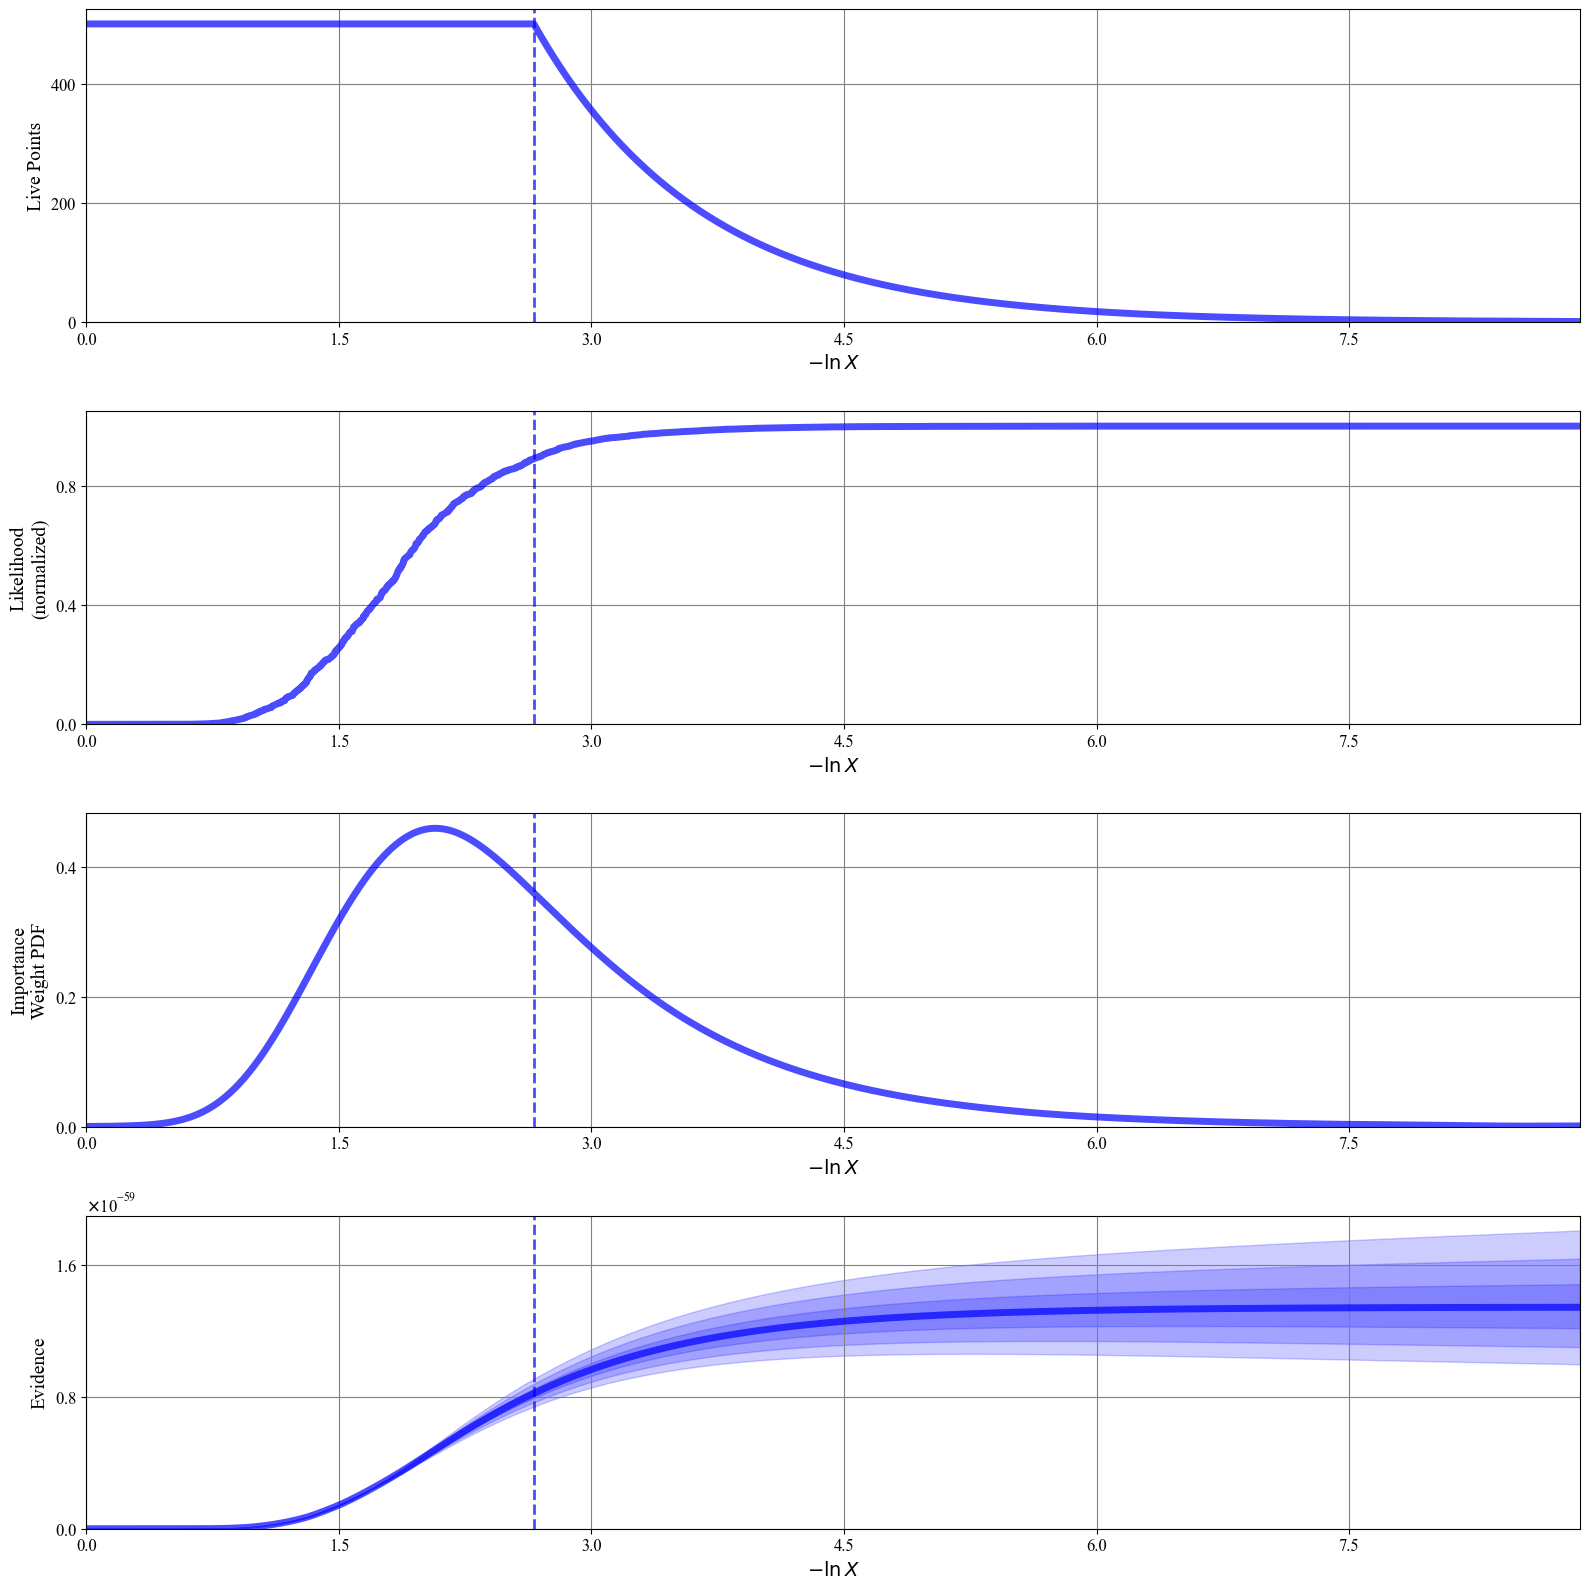

In [48]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

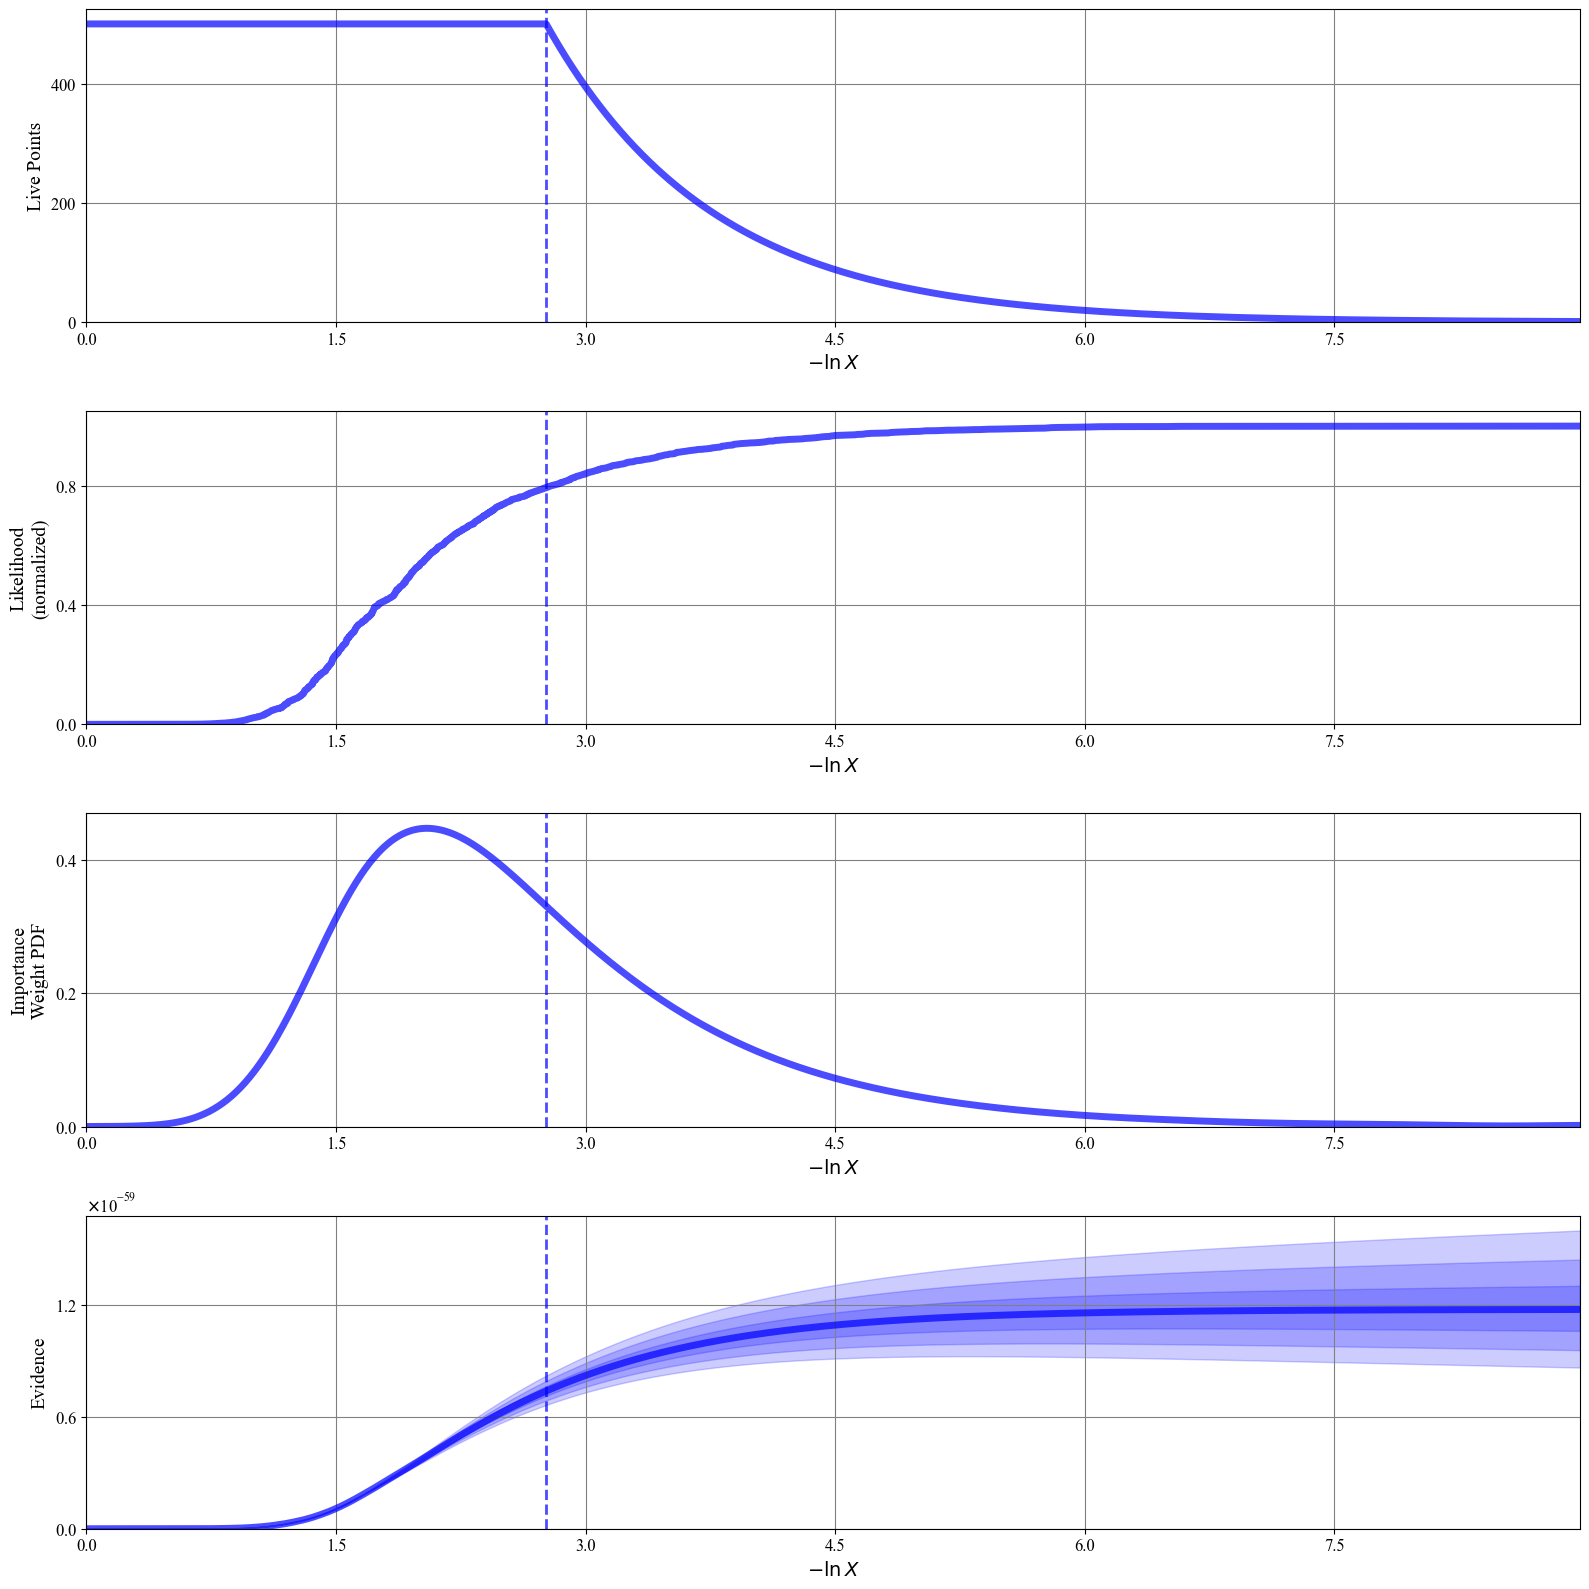

In [49]:
rfig, raxes = dyplot.runplot(sresults2)

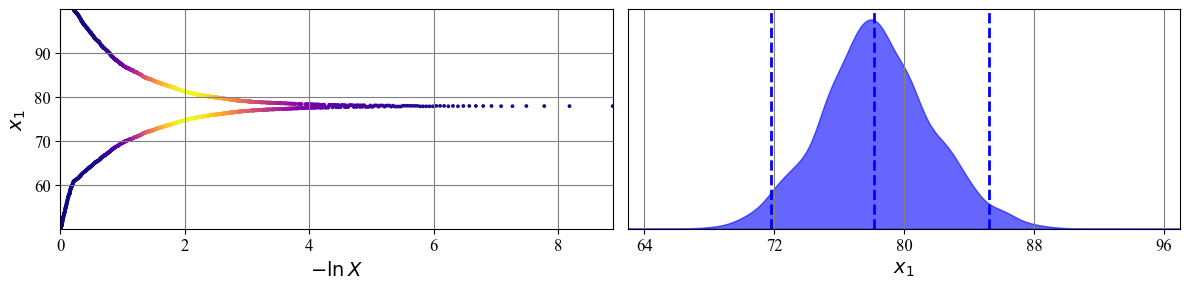

In [50]:
tfig, taxes = dyplot.traceplot(sresults)

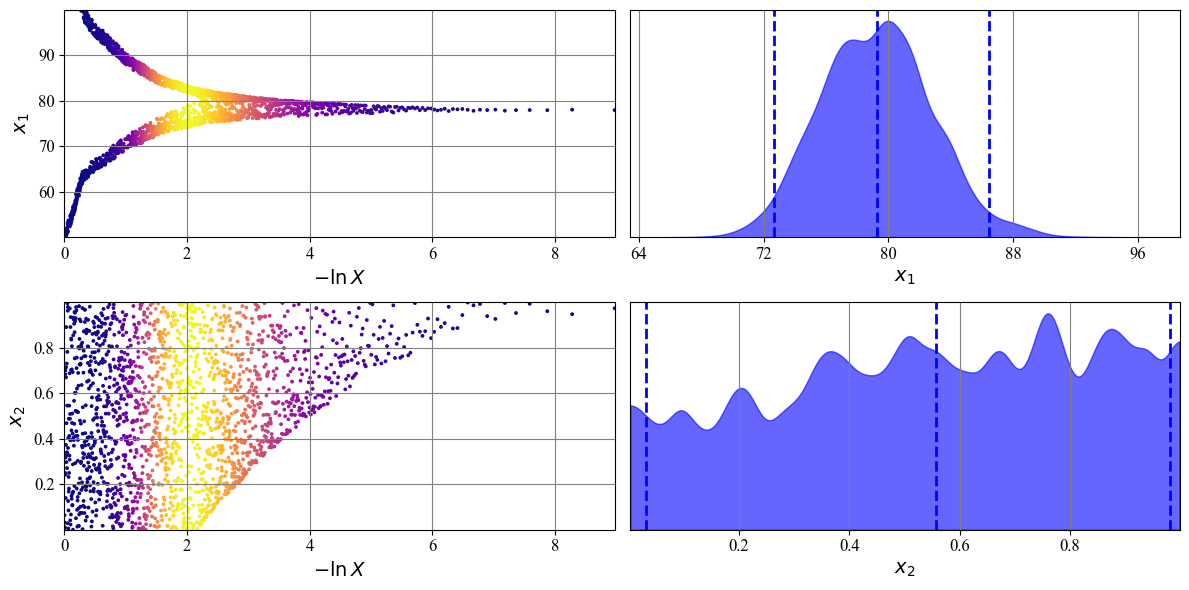

In [51]:
tfig, taxes = dyplot.traceplot(sresults2)

In [54]:
from dynesty import utils as dyfunc


# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 1.3416429943866935e-59
68% parameter credible regions are:
 [[75.042260287459, 81.65298774071064]]

Mean and covariance of parameters are: [78.25664539]
[[11.46761765]]


In [55]:
# Extract sampling results.
samples2 = sresults2.samples  # samples
weights2 = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights


evidence2 = sresults2.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles2 = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights2)
             for samps in samples2.T]
print('68% parameter credible regions are:\n ' + str(quantiles2) + '\n')

# Compute weighted mean and covariance.
mean2, cov2 = dyfunc.mean_and_cov(samples2, weights2)
print('Mean and covariance of parameters are: ' + str(mean2) + '\n' + str(cov2))

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 1.3416429943866935e-59
68% parameter credible regions are:
 [[75.64985457443693, 82.7229631436774], [0.21547402027123205, 0.865567647031646]]

Mean and covariance of parameters are: [79.2361673   0.54582902]
[[12.51011442 -0.22411629]
 [-0.22411629  0.07732015]]


In [56]:
samples_equal = dyfunc.resample_equal(samples, weights)

In [57]:
samples_equal2 = dyfunc.resample_equal(samples2, weights2)

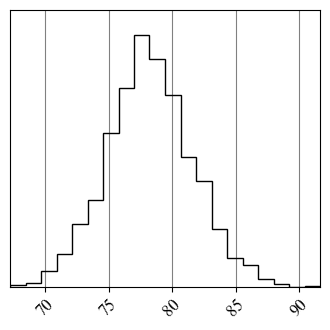

In [58]:
import corner
corner.corner(samples_equal);

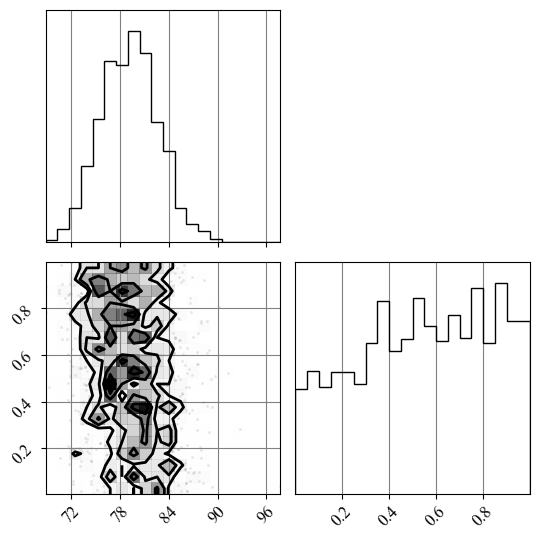

In [59]:
import corner
corner.corner(samples_equal2);

In [62]:
# Redshift grid for predictions
z_plot = np.linspace(0.001, 2.0, 500)

# Number of posterior samples to draw
n_samples = 1000

# ----------------------------
# MODEL 1 (Omega_m = 1)
# ----------------------------
posterior_samples_1 = res1.samples[np.random.choice(len(res1.samples), n_samples)]
mu_samples_1 = []

for H0, in posterior_samples_1:
    mu_i = mu_theoretical2(z_plot, H0)
    mu_samples_1.append(mu_i)

mu_samples_1 = np.array(mu_samples_1)

mu_med_1 = np.percentile(mu_samples_1, 50, axis=0)
mu_low_1 = np.percentile(mu_samples_1, 16, axis=0)
mu_high_1 = np.percentile(mu_samples_1, 84, axis=0)

# ----------------------------
# MODEL 2 (free Omega_m)
# ----------------------------
posterior_samples_2 = res2.samples[np.random.choice(len(res2.samples), n_samples)]
mu_samples_2 = []

for H0, omega_m in posterior_samples_2:
    mu_i = mu_theoretical(z_plot, H0, omega_m)
    mu_samples_2.append(mu_i)

mu_samples_2 = np.array(mu_samples_2)

mu_med_2 = np.percentile(mu_samples_2, 50, axis=0)
mu_low_2 = np.percentile(mu_samples_2, 16, axis=0)
mu_high_2 = np.percentile(mu_samples_2, 84, axis=0)

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ricca\AppData\Local\Temp\ipykernel_6212\4036571003.py:16: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


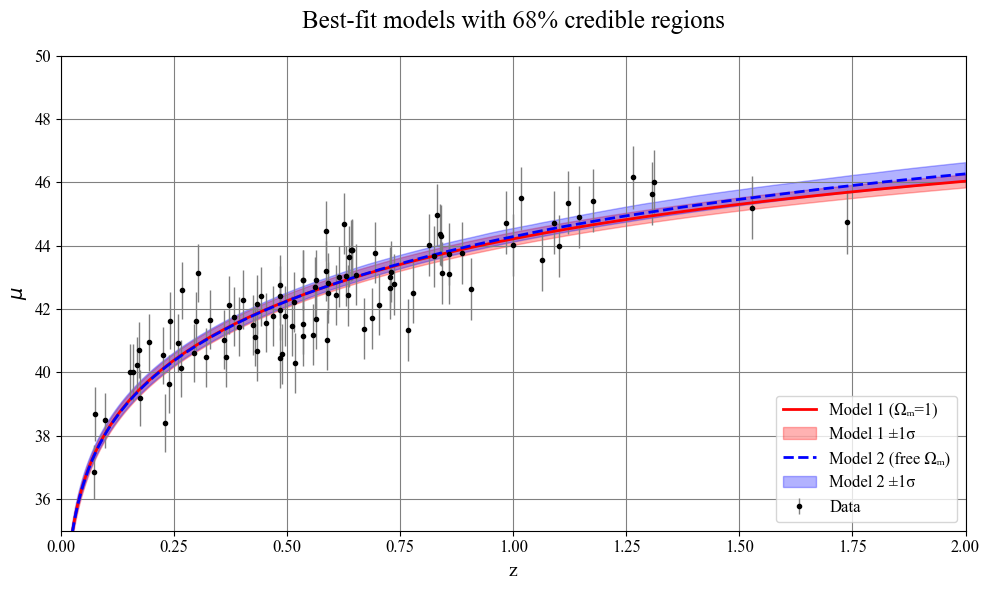

In [63]:
plt.figure(figsize=(10, 6))

# Data
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

# Model 1
plt.plot(z_plot, mu_med_1, 'r-', label='Model 1 (Ωₘ=1)')
plt.fill_between(z_plot, mu_low_1, mu_high_1, color='red', alpha=0.3, label='Model 1 ±1σ')

# Model 2
plt.plot(z_plot, mu_med_2, 'b--', label='Model 2 (free Ωₘ)')
plt.fill_between(z_plot, mu_low_2, mu_high_2, color='blue', alpha=0.3, label='Model 2 ±1σ')

# Formatting
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Best-fit models with 68% credible regions")
plt.savefig('Final_plot.png')